In [103]:
import numpy as np
import cv2
import math
import time
import csv
import socket
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
from my_functions import *
from my_param import *

### Read net config csv

In [104]:
csv_data = read_csv('C:/CNN_VHDL/python/net-config.csv', 4)
# print(csv_data)
net_config = float_to_int_list(csv_data)
print(net_config)
# print(len(net_config))
layers, conv_type, input_resolution, in_res, out_res, ch_in_conv, ch_out_conv, ch_in_fc, ch_out_fc, fname_conv, fname_fc_w, fname_fc_b, y_lim, x_lim = decode_net_layers(net_config,1)
print('layers',layers)
print(input_resolution)
print(in_res, out_res)
# print(fname_fc_w[0])
print(ch_in_conv, ch_out_conv)
print(ch_in_fc, ch_out_fc)
print(conv_type)
print('y_lim',y_lim,'x_lim',x_lim)

Processed 6 lines.
[0, 240, 320, 3, 4, 3, 16, 0, 4, 16, 24, 0, 4, 24, 32, 0, 5, 38400, 1024, 0, 5, 1024, 240, 0]
Input image
Conv+BN+ReLU+MaxPool
Conv+BN+ReLU+MaxPool
Conv+BN+ReLU+MaxPool
FC
FC
layers [1, 3, 3, 3, 3, 2]
[240, 320, 3]
[76800, 19200, 4800] [19200, 4800, 1200]
[3, 16, 24] [16, 24, 32]
[38400, 1024] [1024, 240]
[4, 4, 4]
y_lim [240, 120, 60] x_lim [320, 160, 80]


In [105]:
in_res

[76800, 19200, 4800]

### Compress Conv+BN layers

In [106]:
print(ch_in_conv)
print(ch_out_conv)
all_conv_layers = []
for layer_idx in range(len(ch_in_conv)):
    print("\x1b[34mConv layer:\x1b[0m " + str(layer_idx))
    raw_layer_conv = read_csv('C:/CNN_VHDL/python/'+fname_conv[layer_idx], 8)
    conv_layer = restructure_conv_bn_layer(raw_layer_conv, ch_in_conv[layer_idx], ch_out_conv[layer_idx])
    print("\x1b[34mIn/out:\x1b[0m " + str(ch_in_conv[layer_idx]) + '/' + str(ch_out_conv[layer_idx]))
    for i in range(0,math.ceil(ch_out_conv[layer_idx]/8)):
        for j in range(0,math.ceil(ch_in_conv[layer_idx]/8)):
            print("\x1b[31mFilter:\x1b[0m " + str(j) + '->' + str(i))
            shift = 128*j + 128*math.ceil(ch_in_conv[layer_idx]/8)*i
            for k in range(0,32):
                print(conv_layer[shift+k*4:shift+(k+1)*4])
    all_conv_layers.extend(conv_layer)
    print(' ')
print(len(all_conv_layers))
raw_sum_conv = read_csv('C:/CNN_VHDL/python/net-Bkabe-sum.csv', 8)
print('raw_sum_conv')
print(raw_sum_conv)
sum_conv = restructure_conv_bn_layer(raw_sum_conv, [], [])
print('sum_conv')
print(sum_conv)
all_conv_layers = insert_summation_core(all_conv_layers,sum_conv) # Fill 0-15 cores, 15th core is a summation core
print('all_conv_layers')
print(all_conv_layers)
len(all_conv_layers)

[3, 16, 24]
[16, 24, 32]
Conv layer: 0
Processed 64 lines.
In/out: 3/16
Filter: 0->0
[21299400, 58, 0, 0]
[461971071, 5784, 0, 0]
[55460, 0, 0, 0]
[0, 0, 0, 0]
[33226970, 106, 0, 0]
[333123645, 3719, 0, 0]
[10023, 0, 0, 0]
[0, 0, 0, 0]
[13631980, 95, 0, 0]
[613100880, 9445, 0, 0]
[9708, 0, 0, 0]
[0, 0, 0, 0]
[23724405, 24, 0, 0]
[307109024, 12403, 0, 0]
[55697, 0, 0, 0]
[0, 0, 0, 0]
[27263254, 207, 0, 0]
[2213847757, 55816, 0, 0]
[6713, 0, 0, 0]
[0, 0, 0, 0]
[17432925, 369, 0, 0]
[1710517158, 27263, 0, 0]
[8720, 0, 0, 0]
[0, 0, 0, 0]
[10879266, 12, 0, 0]
[224400065, 3531, 0, 0]
[55677, 0, 0, 0]
[0, 0, 0, 0]
[4653142, 209, 0, 0]
[774448452, 11358, 0, 0]
[56439, 0, 0, 0]
[0, 0, 0, 0]
Filter: 0->1
[917613, 421, 0, 0]
[1795070824, 35197, 0, 0]
[63431, 0, 0, 0]
[0, 0, 0, 0]
[1900855, 99, 0, 0]
[797263942, 12521, 0, 0]
[8630, 0, 0, 0]
[0, 0, 0, 0]
[10813467, 47, 0, 0]
[1295205372, 20427, 0, 0]
[61051, 0, 0, 0]
[0, 0, 0, 0]
[9437270, 275, 0, 0]
[367463457, 4428, 0, 0]
[55665, 0, 0, 0]
[0, 0, 

FileNotFoundError: [Errno 2] No such file or directory: 'C:/CNN_VHDL/python/net-Bkabe-sum.csv'

### Compress FC layers

In [109]:
print(ch_in_fc, ch_out_fc)
print(fname_fc_w)
print(fname_fc_b)
all_fc_w = []
all_fc_b = []
for layer_idx in range(len(ch_in_fc)): # 
    print('layer_idx:',layer_idx)
    if layer_idx==0: # if Conv -> FC1
        kanalu_sluoksnio_iejime = ch_out_conv[-1]
    else: # if FC1 -> FC2
        kanalu_sluoksnio_iejime = 2 # nes irase i dvi skirtingas vietas DDR, skaitant bus CH0, CH1 
    samplu_input_kanale = int(round(ch_in_fc[layer_idx]/kanalu_sluoksnio_iejime))
    raw_fc_w = read_csv('C:/CNN_VHDL/python/'+fname_fc_w[layer_idx], samplu_input_kanale)
    if layer_idx==0:
        raw_fc_w = reorder_fc_w(raw_fc_w,kanalu_sluoksnio_iejime,8)
    else:
        raw_fc_w = reorder_fc_w(raw_fc_w,kanalu_sluoksnio_iejime,2)
    fc_w = restructure_fc_w(raw_fc_w,0,0)
    all_fc_w.extend(fc_w)

    raw_fc_b = read_csv('C:/CNN_VHDL/python/'+fname_fc_b[layer_idx], ch_out_fc[layer_idx])
#     if layer_idx==0:
#         fc_b = restructure_fc_b(raw_fc_b,0,0,0)
#     else:
#         fc_b = restructure_fc_b(raw_fc_b,0,0,1)
    fc_b = restructure_fc_b(raw_fc_b,0,0,1)
    
    all_fc_b.extend(fc_b)
# print(all_conv_layers)
print('len:', len(all_conv_layers))
# print(fc_b[0])
print('len:', len(all_fc_w))
# print(all_fc_b)
print('len:', len(all_fc_b))

[38400, 1024] [1024, 240]
['net-1fc_w.csv', 'net-2fc_w.csv']
['net-1fc_b.csv', 'net-2fc_b.csv']
layer_idx: 0
Processed 32768 lines.
Processed 1 lines.
layer_idx: 1
Processed 480 lines.
Processed 1 lines.
len: 2560
len: 19783680
len: 632


### Get Base adresses

In [110]:
DDR_BASE = 0x01000000
# IMG_BASE = DDR_BASE
# IMG_ZERO = IMG_BASE+0x00400000
IMG_BASE = DDR_BASE
IMG_ZERO = DDR_BASE + 0x00400000
NET_BASE = IMG_BASE + 0x00800000 # Reserve 8MB for input image
INSTR_BASE = NET_BASE + shift_step_4096(4*len(net_config),4096) # 4B=32b/number
CORE_BASE = NET_BASE + shift_step_4096(0x00100000,4096) # Reserve 1MB for net_config & instructions, ~32k instructions available (32B per instr.)
FC1_W_BASE = CORE_BASE + shift_step_4096(4*len(all_conv_layers),4096) # 4B/2CH -> 2B/CH -> 2B/sample
FC2_W_BASE = FC1_W_BASE + (ch_in_fc[0]*ch_out_fc[0]*2) # 2B/sample
FC1_B_BASE = FC1_W_BASE + shift_step_4096(4*len(all_fc_w),4096) # 4B/2CH -> 2B/CH -> 2B/sample
FC2_B_BASE = FC1_B_BASE + (ch_out_fc[0]*2) # 2B/sample
TEMP_BASE = FC1_B_BASE + shift_step_4096(ch_out_fc[1]*2,4096) # 2B/sample # max FC1 1024 neur. + FC2 1024 neur.
RES_BASE = shift_step_4096(0xFF000000,4096) # result base, where to store FC2 outputs, 0x11F00000
base_addresses = [IMG_BASE,NET_BASE,INSTR_BASE,CORE_BASE,FC1_W_BASE,FC2_W_BASE,FC1_B_BASE,FC2_B_BASE,TEMP_BASE,RES_BASE]

for i in range(0,len(base_addresses)):
    print(hex(base_addresses[i]))
# print(ch_out_fc[1]*2)

0x1000000
0x1800000
0x1801000
0x1900000
0x1903000
0x6403000
0x647b000
0x647b800
0x647c000
0xff000000


### Join conv instuction list

In [111]:
lista = []
lista.append([1,2,3])
lista.append([1,2,3,4])
print(lista)
dst0_Lout_cfgs = []
sum_on_Lout = []
for i in range(0,len(ch_in_conv)):
    if ch_in_conv[i] > 8:
        dst0_Lout_cfgs.append(math.ceil(ch_out_conv[i]/4))
        sum_on_Lout.append(1)
    else:
        dst0_Lout_cfgs.append(math.ceil(ch_in_conv[i]/8)*math.ceil(ch_out_conv[i]/8))
        sum_on_Lout.append(0)
print(dst0_Lout_cfgs)
print(sum_on_Lout)

[[1, 2, 3], [1, 2, 3, 4]]
[2, 6, 8]
[0, 1, 1]


In [112]:
# Destination addresses on layer output Lout
BpCH = 2 # Bytes per channel = 2 (by default)
CHpD = 4 # Channels per DMA = 4 (by default)
# in_res = [1, 1, 1]
# out_res = [1, 1, 1]

# ch_in_conv = [3,32,128]
# ch_out_conv = [32,128,256]
# ch_in_conv = [3,8,16]
# ch_out_conv = [8,16,32]
# ch_in_conv = [3,32,8]
# ch_out_conv = [32,8,32]
# ch_in_conv = [3,32,32]
# ch_out_conv = [32,32,32]
# ch_in_conv = [3,8,16]
# ch_out_conv = [8,16,8]
print('ch_in_conv',ch_in_conv,'ch_out_conv',ch_out_conv)
print('input_resolution',input_resolution)
print('in_res',in_res,'out_res',out_res)
core_cfgs, inout_core_cfgs = get_conv_cfgs(ch_in_conv,ch_out_conv)
print('core_cfgs',core_cfgs,'inout_core_cfgs',inout_core_cfgs)
dst0_Lout_cfgs, sum_on_Lout = get_dst0_Lout_cfgs(ch_in_conv,ch_out_conv)
print('dst0_Lout_cfgs',dst0_Lout_cfgs,'sum_on_Lout',sum_on_Lout)
sizeRX = 0
sizeTX = 0
dst0_Lout = []
dst1_Lout = []
Sdst1 = TEMP_BASE # Sdst0 = TEMP_BASE # 2020-02-27
# S_dst_1 = TEMP_BASE
for l in range(layers[1]): # loop over all conv layers
    dst0 = []
    dst1 = []
    for c in range(dst0_Lout_cfgs[l]): # loop over all conv dst0_Lout_cfgs in l-th layer
#         size_TX = in_res[l]*4*2 # X*Y * CH/DMA * Bytes/sample
#         size_RX = out_res[l]*4*2
        if l==0 or ch_in_conv[l]<=8: # if 1st layer or num of input CH in l-th layer fits single core then don't use sum cores in that layer
            Sdst0 = Sdst1 + shift_step_4096(sizeRX,4096) # Sdst0 = Sdst0 + shift_step_4096(sizeRX,4096) # 2020-02-27
            dst0.append(Sdst0)
            sizeRX = out_res[l]*CHpD*BpCH # for dst1
            Sdst1 = Sdst0 + shift_step_4096(sizeRX,4096)
            dst1.append(Sdst1)
            sizeRX = sizeRX + sizeRX # for next dst0
        else: # num of input CH is more than input CH in a core
            Sdst0 = Sdst0 + shift_step_4096(sizeRX,4096)
            dst0.append(Sdst0)
            sizeRX = out_res[l]*CHpD*BpCH
#             print('L',l,'C',c)
    dst0_Lout.append(dst0)
    dst1_Lout.append(dst1)
FC1_DATA_BASE = dst0_Lout[-1][0]
# print('dst0',dst0)
# print('dst1',dst1)
print('dst0_Lout',dst0_Lout)
print('dst1_Lout',dst1_Lout)
new_dst = max(Sdst0,Sdst1)+shift_step_4096(sizeRX,4096)
print('new_dst',new_dst)

# Source addresses on layer input
src0_Lin, src1_Lin = get_source_addresses_on_layer_input(layers,inout_core_cfgs,IMG_BASE,IMG_ZERO,sum_on_Lout,dst0_Lout,dst1_Lout)
len(all_conv_layers)

ch_in_conv [3, 16, 24] ch_out_conv [16, 24, 32]
input_resolution [240, 320, 3]
in_res [76800, 19200, 4800] out_res [19200, 4800, 1200]
core_cfgs [2, 6, 12] inout_core_cfgs [1, 2, 3, 4]
dst0_Lout_cfgs [2, 6, 8] sum_on_Lout [0, 1, 1]
dst0_Lout [[105365504, 105828352], [106135552, 106176512, 106217472, 106258432, 106299392, 106340352], [106381312, 106393600, 106405888, 106418176, 106430464, 106442752, 106455040, 106467328]]
dst1_Lout [[105521152, 105984000], [], []]
new_dst 106479616
src0_Lin [[16777216, 16777216], [105365504, 105828352, 105365504, 105828352, 105365504, 105828352], [106135552, 106217472, 106299392, 106135552, 106217472, 106299392, 106135552, 106217472, 106299392, 106135552, 106217472, 106299392]]
src1_Lin [[20971520, 20971520], [105521152, 105984000, 105521152, 105984000, 105521152, 105984000], [106176512, 106258432, 106340352, 106176512, 106258432, 106340352, 106176512, 106258432, 106340352, 106176512, 106258432, 106340352]]


2560

In [113]:
# Destination addresses on intermediate conv/sum cores
i = 0 # tmp core idx
j = 0 # only conv core index
k = 0 # all core update and conv+sum core index
l = 0 # layer 0
ccbi = 0 # conv core batch index
dst0_conv = []
dst1_conv = []
dst_b0 = new_dst
CCS = 512 # CONST - Conv Core Size, Bytes
CCBS = 15 # CONST - Conv Core Batch Size (w/o summation core)
# all_conv_layers.extend(all_conv_layers)
total_conv_cores = int(4*len(all_conv_layers)/CCS) # int(4*16384/CCS) # 
total_conv_core_updates = math.ceil((total_conv_cores-1)/CCBS)
conv_core_batch_vctr = get_conv_core_batch_vctr(total_conv_cores)
print('total_conv_cores',total_conv_cores)
print('total_conv_core_updates',total_conv_core_updates)
print('conv_core_batch_vctr',conv_core_batch_vctr)
# 0x01-conv | 0x02-conv+bn | 0x03-conv+bn+relu | 0x04-conv+bn+relu+pool | 0x10-update conv w | 0x12-sum | 0x13-sum + relu | 0x14-sum + relu + pool
# instr0 | instr1 | sizeTX | sizeRX | src_0 | src_1 | dst_0 | dst_1
instrlist=[]
layerlist=[]
size_TX = conv_core_batch_vctr[0]*CCS
size_RX = 0
src_0 = CORE_BASE # dma0 addr
src_1 = 0 # dma1 addr
dst_0 = 0 # dma2 addr
dst_1 = 0 # dma3 addr
# instrlist, k, layerlist = insert_instr_to_list(k,0x10,0,sizeTX,sizeRX,src_0,src_1,dst_0,dst_1,instrlist,l,layerlist) # 1st 16 conv cores cfg
instrlist, ccbi, k, layerlist = insert_core_cfg_update_instr(k,j,CCBS,CCS,ccbi,conv_core_batch_vctr,CORE_BASE,instrlist,l,layerlist,total_conv_cores)
# layerlist.append(0)
for l in range(layers[1]): # loop over all conv layers
    yx_lim = get_yx_lim(y_lim[l],x_lim[l])
    dst0 = []
    dst1 = []
#     sizeRX = in_res[l]*CHpD*BpCH # for dst0, in_res because it is not output core in l-th layer
#     sizeTX = sizeRX
    if sum_on_Lout[l]: # if l-th layer contains summation cores
        Nin_cores = inout_core_cfgs[l] # num of conv cores in l-th layer
        Nout_cores = inout_core_cfgs[l+1]
        print('In layer',l,'Nin_cores',Nin_cores,'Nout_cores',Nout_cores)
        for co in range(Nout_cores): # co - core output
            i=0 # conv core idx for certain block of 8CH outs
            for ci in range(Nin_cores-1): # ci - core input
                print('Core out',co,'in',ci)
#                 conv cores
                sizeRX = in_res[l]*CHpD*BpCH # for dst1, in_res because it is not output core in l-th layer
                sizeTX = sizeRX
                if i==0: # first conv core store to b0, b1 addr
                    dst0.append(dst_b0)
                    dst_b1 = dst_b0 + shift_step_4096(sizeRX,4096)
                    dst1.append(dst_b1)
#                     sizeRX = sizeRX + sizeRX # for next dst0
                    src_0 = src0_Lin[l][i] # EDIT
                    src_1 = src1_Lin[l][i] # EDIT
                    dst_0 = dst_b0
                    dst_1 = dst_b1
                    instrlist, k, layerlist = insert_instr_to_list(k,0x02,yx_lim,sizeTX,sizeRX,src_0,src_1,dst_0,dst_1,instrlist,l,layerlist)
#                     layerlist.append(l)
                    i=i+1
                    j=j+1
                    instrlist, ccbi, k, layerlist = insert_core_cfg_update_instr(k,j,CCBS,CCS,ccbi,conv_core_batch_vctr,CORE_BASE,instrlist,l,layerlist,total_conv_cores)
#                     next conv core store to a0, a1 addr
                    dst_a0 = new_dst + shift_step_4096(sizeRX*2,4096)
                    dst0.append(dst_a0)
#                     sizeRX = in_res[l]*CHpD*BpCH # for dst1
                    dst_a1 = dst_a0 + shift_step_4096(sizeRX,4096)
                    dst1.append(dst_a1)
#                     sizeRX = sizeRX + sizeRX # for next dst0, sum core
                    src_0 = src0_Lin[l][i] # EDIT
                    src_1 = src1_Lin[l][i] # EDIT
                    dst_0 = dst_a0
                    dst_1 = dst_a1
                    instrlist, k, layerlist = insert_instr_to_list(k,0x02,yx_lim,sizeTX,sizeRX,src_0,src_1,dst_0,dst_1,instrlist,l,layerlist)
#                     layerlist.append(l)
                    i=i+1
                    j=j+1
                    instrlist, ccbi, k, layerlist = insert_core_cfg_update_instr(k,j,CCBS,CCS,ccbi,conv_core_batch_vctr,CORE_BASE,instrlist,l,layerlist,total_conv_cores)
                    dst_c0 = dst_a0 + shift_step_4096(sizeRX*2,4096)
                    dst_c1 = dst_a0 + shift_step_4096(sizeRX*3,4096)
                else: # next conv core
                    dst0.append(dst_a0)
                    dst1.append(dst_a1)
                    dstn0 = dst_a0
                    dstn1 = dst_a1
#                     print('Conv','dst0',dstn0,'dst1',dstn1)
                    src_0 = src0_Lin[l][i] # EDIT
                    src_1 = src1_Lin[l][i] # EDIT
                    dst_0 = dst_a0
                    dst_1 = dst_a1
                    instrlist, k, layerlist = insert_instr_to_list(k,0x02,yx_lim,sizeTX,sizeRX,src_0,src_1,dst_0,dst_1,instrlist,l,layerlist)
#                     layerlist.append(l)
                    i=i+1
                    j=j+1
                    instrlist, ccbi, k, layerlist = insert_core_cfg_update_instr(k,j,CCBS,CCS,ccbi,conv_core_batch_vctr,CORE_BASE,instrlist,l,layerlist,total_conv_cores)
#                 sum core
                if i==Nin_cores: # last summation core
                    dstn0 = dst0_Lout[l][2*co+0]
                    dstn1 = dst0_Lout[l][2*co+1]
#                     print('Sum last','dst0',dstn0,'dst1',dstn1)
                    sizeRX = out_res[l]*CHpD*BpCH
                    cmd0=conv_type[l]+0x10
                else:
                    if i%2==0: # even sum core to c addr
                        dstn0 = dst_c0
                        dstn1 = dst_c1
                    else: # odd sum core to b addr
                        dstn0 = dst_b0
                        dstn1 = dst_b1
#                     print('Sum not last','dst0',dstn0,'dst1',dstn1)
                    sizeRX = in_res[l]*CHpD*BpCH
                    cmd0=0x10+0x02
                if i%2==0: # even sum load from addr b
                    srcn0 = dst_b0
                    srcn1 = dst_b1
                else: # odd sum load from addr c
                    srcn0 = dst_c0
                    srcn1 = dst_c1
#                 sizeTX = in_res[l]*CHpD*BpCH # CH/DMA * Bytes/CH
#                 sizeRX = out_res[l]*CHpD*BpCH
                src_0 = dst_a0 # EDIT
                src_1 = srcn0 # EDIT
                dst_0 = dstn0
                dst_1 = 0 # UNUSED
                instrlist, k, layerlist = insert_instr_to_list(k,cmd0,yx_lim,sizeTX,sizeRX,src_0,src_1,dst_0,dst_1,instrlist,l,layerlist)
#                 layerlist.append(l)
                dst0.append(dstn0)
                
                src_0 = dst_a1 # EDIT
                src_1 = srcn1 # EDIT
                dst_0 = dstn1
                dst_1 = 0 # UNUSED
                instrlist, k, layerlist = insert_instr_to_list(k,cmd0,yx_lim,sizeTX,sizeRX,src_0,src_1,dst_0,dst_1,instrlist,l,layerlist)
#                 layerlist.append(l)
                dst1.append(dstn1)
    else: # layer without summations, execute pure conv cores
        print('In layer',l,'no summation cores')
        for c in range(0,core_cfgs[l]): # loop over all conv configs in L-th layer
            print('Core',c)
            sizeTX = in_res[l]*CHpD*BpCH # CH/DMA * Bytes/CH
            sizeRX = out_res[l]*CHpD*BpCH
            if l==0: # read image
                src_0 = IMG_BASE # color image in CH0, CH1, CH2. Grey in CH0, CH3=0
                src_1 = IMG_ZERO # address to zeros for CH4=CH5=CH6=CH7=0
            else: # read dst addr of prev. layer
                src_0 = src0_Lin[l][c] # EDIT
                src_1 = src1_Lin[l][c] # EDIT
            dst_0 = dst0_Lout[l][c]
            dst_1 = dst1_Lout[l][c]
            instrlist, k, layerlist = insert_instr_to_list(k,conv_type[l],yx_lim,sizeTX,sizeRX,src_0,src_1,dst_0,dst_1,instrlist,l,layerlist)
#             layerlist.append(l)
            j=j+1
            instrlist, ccbi, k, layerlist = insert_core_cfg_update_instr(k,j,CCBS,CCS,ccbi,conv_core_batch_vctr,CORE_BASE,instrlist,l,layerlist,total_conv_cores)
    dst0_conv.append(dst0)
    dst1_conv.append(dst1)
print('dst0_conv',dst0_conv)
print('dst1_conv',dst1_conv)
print('Total conv executed',j,'total conv_updates+conv+sum',k)
# print(instrlist)
for i in range(0,k):
    print(layerlist[i],instrlist[i])
    instrlist[i][0]=instrlist[i][0]+layerlist[i]*2**16 # add layer index (hi 16b) to cmd (lo 16b)
instr_list = []
for i in range(0,len(instrlist)):
    instr_list.extend(instrlist[i])
base_addresses.append(k) # add number of instructions in conv layer
base_addresses.append(FC1_DATA_BASE) # add FC1 input data base address
for i in range(len(base_addresses)):
    print(hex(base_addresses[i]))
len(layerlist)

total_conv_cores 20
total_conv_core_updates 2
conv_core_batch_vctr [16, 4]
update core config, j 0
In layer 0 no summation cores
Core 0
Core 1
In layer 1 Nin_cores 2 Nout_cores 3
Core out 0 in 0
Core out 1 in 0
Core out 2 in 0
In layer 2 Nin_cores 3 Nout_cores 4
Core out 0 in 0
Core out 0 in 1
Core out 1 in 0
Core out 1 in 1
Core out 2 in 0
update core config, j 15
Core out 2 in 1
Core out 3 in 0
Core out 3 in 1
dst0_conv [[], [106479616, 106786816, 106135552, 106479616, 106786816, 106217472, 106479616, 106786816, 106299392], [106479616, 106557440, 106635264, 106557440, 106381312, 106479616, 106557440, 106635264, 106557440, 106405888, 106479616, 106557440, 106635264, 106557440, 106430464, 106479616, 106557440, 106635264, 106557440, 106455040]]
dst1_conv [[], [106635264, 106942464, 106176512, 106635264, 106942464, 106258432, 106635264, 106942464, 106340352], [106520576, 106598400, 106676224, 106598400, 106393600, 106520576, 106598400, 106676224, 106598400, 106418176, 106520576, 10659840

44

In [115]:
print('ccbi',ccbi)
conv_instr=[0]*19
add_instr=[0]*19
for i in range(0,k): # kiek conv/add instr. layeriuose?
    idx = layerlist[i]
    if (instrlist[i][0] & 0xFFFF) < 16:
        conv_instr[idx]=conv_instr[idx]+1
    elif (instrlist[i][0] & 0xFFFF) > 16:
        add_instr[idx]=add_instr[idx]+1
print('conv_instr',conv_instr)
print('add_instr',add_instr)
print('sum conv_instr',sum(conv_instr))
print('sum add_instr',sum(add_instr))

ccbi 2
conv_instr [2, 6, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
add_instr [0, 6, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
sum conv_instr 20
sum add_instr 22


### Memory

In [116]:
max_dst = max(instr_list)
print('max_dst',hex(max_dst))
DDR_CONV_MB = (max_dst-CORE_BASE)/1024/1024 # without image and instruction memory
print("Memory for conv layers: %.3f" % DDR_CONV_MB,'MB')
print('old RES_BASE',hex(RES_BASE))
RES_BASE = shift_step_4096(max_dst+2**20,4096) # 1MB shift after last conv destination address
base_addresses[9] = RES_BASE # update FC2 result address
print('new RES_BASE',hex(RES_BASE))

max_dst 0x65fd000
Memory for conv layers: 76.988 MB
old RES_BASE 0xff000000
new RES_BASE 0x66fd000


# Configure socket

In [118]:
# client.close()
kontrolerio_ip = "192.168.3.10" # IP
kontrolerio_port = 7            # PORT
client = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
address = (kontrolerio_ip, kontrolerio_port)
client.connect(address)

### Send BASE addresses

In [119]:
format_and_send(client, base_addresses, 0x09, 0) # + auto clean DDR memory
format_and_send(client, [], 0xFF, 0)

### Send net-config

In [120]:
format_and_send(client, net_config, 0x02, 0)
format_and_send(client, [], 0xFF, 0) # send EoS (End of Stream) flag

### Send instructions

In [121]:
format_and_send(client, instr_list, 0x08, 2)
format_and_send(client, [], 0xFF, 0)

### Send conv_bn, fc_w, fc_b

In [122]:
format_and_send(client, all_conv_layers, 0x03, 1)


In [123]:
format_and_send(client, [], 0xFF, 0)

In [124]:
format_and_send(client, all_fc_w, 0x04, 2)


In [125]:
format_and_send(client, [], 0xFF, 0)

In [126]:
format_and_send(client, all_fc_b, 0x05, 1)
format_and_send(client, [], 0xFF, 0)
# format_and_send(client, [], 0x06, 0) # disp info
# format_and_send(client, [], 0xFF, 0)
# print(hex(all_fc_b[5]))

### Read image

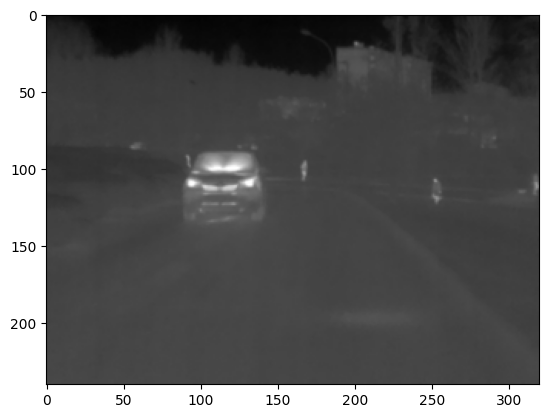

[16 16 16]
[16777472, 256, 14680288, 224]


[240, 320, 3]

In [127]:
## Load normal image
img_bmp = mpimg.imread('fir.bmp') # image1024x256 image512x128 image256x64 image128x32 | image = 512x512
input_resolution=[240, 320, 3]

# ### Reset img pixels, write zeros to 8MB memory
# img_bmp = mpimg.imread('fir512x1024.bmp'); input_resolution=[512, 1024, 3]

img_bmp = img_bmp[0:input_resolution[0],0:input_resolution[1],:] # raiska = input_resolution | img_bmp = img_bmp[0:128,0:128,:]
plt.imshow(img_bmp) # , cmap=None, vmin=0, vmax=5
plt.show()

img_as_list = restructure_img(img_bmp,input_resolution)
print(img_bmp[0,0,:])
print(img_as_list[0:4]);
input_resolution

### Send image

In [128]:
format_and_send(client, img_as_list, 0x01, 1)

In [129]:
format_and_send(client, [], 0xFF, 0)

# Run CNN get FC2

In [130]:
format_and_send(client, [], 0x07, 0) # call_cnn()
format_and_send(client, [], 0xFF, 0)

received_FC2 = recvall(client, ch_out_fc[-1]*2) # len(img_as_list)
# received_FC1 = recvall(client, ch_out_fc[0]*2)
# print(received_data)
print('FC2 Packet length', len(received_FC2))
# print('FC1 Packet length', len(received_FC1))
# client.close()

FC2 Packet length 480


In [131]:
fc2_out = two_bytes_to_sample(received_FC2, ch_out_fc[-1])
fc2_out_f = []
for i in range(0,ch_out_fc[-1]):
    fc2_out_f.append(fc2_out[i]/2**prec)
print(fc2_out_f)
np.savetxt('FC2_FPGA.csv', (fc2_out_f), delimiter=',')

[0.1962890625, 5.81005859375, 3.451416015625, 7.1044921875, -4.830322265625, -5.766845703125, -0.613037109375, -0.105224609375, 0.079345703125, 4.195068359375, 1.914794921875, 6.874267578125, 4.44140625, -2.69482421875, -1.0068359375, -6.948486328125, 0.87939453125, -6.06787109375, -1.307373046875, 3.631103515625, 1.284912109375, 6.89111328125, 3.8740234375, -7.941650390625, -2.46630859375, -6.94677734375, 6.866943359375, 3.931396484375, -4.276611328125, 2.881591796875, 3.452880859375, -3.28759765625, -0.039794921875, 2.623046875, 7.68359375, -6.431640625, -2.872802734375, 2.922607421875, -1.862548828125, 4.505126953125, 7.73779296875, -6.14794921875, -6.82421875, 4.4296875, -5.630615234375, -1.769287109375, -7.539306640625, -3.63330078125, 3.070068359375, 2.65380859375, 2.26025390625, -5.320556640625, -6.209228515625, 4.061767578125, -2.074462890625, -2.19873046875, 3.17578125, 5.141845703125, -5.35107421875, -6.689697265625, 6.86669921875, 6.517822265625, -6.3916015625, -2.0368652343

### Read image, old

In [ ]:
img_bmp = mpimg.imread('fir.bmp') # image1024x256 image512x128 image256x64 image128x32 | image = 512x512
input_resolution=[240, 320, 3] # [2048,2048,3]
img_bmp = img_bmp[0:input_resolution[0],0:input_resolution[1],:] # raiska = input_resolution | img_bmp = img_bmp[0:128,0:128,:]
plt.imshow(img_bmp) # , cmap=None, vmin=0, vmax=5
plt.show()

# img_bmp = cv2.imread('image.bmp') # image1024x256 image512x128 image256x64 image128x32 | image = 512x512
# img_bmp = img_bmp[0:input_resolution[0],0:input_resolution[1],:] # raiska = input_resolution | img_bmp = img_bmp[0:128,0:128,:]
# cv2.imshow('image2', img_bmp)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# print(img_bmp[0,0:4,:]) # [y,x,z] R=[0] G=[1] B=[2]
# img_as_list = restructure_img(img_bmp,input_resolution)
# print(len(img_as_list))
# print(img_as_list[0])
# print(img_as_list[1])

# gray = rgb2gray(img_bmp)
# plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
# plt.show()
# input_resolution=[128,128,3]

img_as_list = restructure_img(img_bmp,input_resolution)
print(img_bmp[0,0,:])
print(img_as_list[0:4]);
input_resolution

In [45]:
# fc1_out = two_bytes_to_sample(received_FC1, ch_out_fc[0])
# fc1_out_f = []
# for i in range(0,ch_out_fc[0]):
#     fc1_out_f.append(fc1_out[i]/2**prec)
# print(fc1_out_f)
# plt.plot(fc1_out_f)
# plt.ylabel('FC1 outputs')
# plt.show()

fc2_out = two_bytes_to_sample(received_FC2, ch_out_fc[-1])
fc2_out_f = []
for i in range(0,ch_out_fc[-1]):
    fc2_out_f.append(fc2_out[i]/2**prec)
print(fc2_out_f)

# FC2 marker
# plt.plot(fc2_out_f)
# plt.ylabel('FC2 outputs')
# plt.show()
# np.savetxt('FC2_FPGA.csv', (fc2_out_f), delimiter=',')

# FC2 class
# clase = np.argmax(fc2_out_f[0:5])
# if clase == 0:
#     print('Lentyna')
# elif clase == 1:
#     print('Kede')
# elif clase == 2:
#     print('Durys')
# elif clase == 3:
#     print('Stalas')
# elif clase == 4:
#     print('Langas')
# else:
#     print('Nezinoma klase')
np.savetxt('FC2_FPGA.csv', (fc2_out_f), delimiter=',')

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [53]:
num=-1.5001
a=((num > 0) - (num < 0)) * int(abs(num) + 0.5)
b=int(a)
print('a',a,'b',b)

a -2 b -2


In [27]:
# RES = 64
# TotalBytes = RES*RES*8
# # Block = 1024
# # Blocks = int(TotalBytes/Block);
# # num8 = []
# # print('Blocks', Blocks)
# # for i in range(0, Blocks):
# #     received_data = recvall(client, Block)
# #     num8.append(received_data)
# #     print('i', i)
# # if TotalBytes%Block>0:
# #     received_data = recvall(client, int(TotalBytes-Block*i))
# #     num8.append(received_data)
# #     print('i=', i+1)
# received_data = recvall(client, TotalBytes)
# # print(received_data)
# # print(len(received_data))
# merged_data = two_bytes_to_sample(received_data, int(RES*RES*8/2))
# # print(merged_data)
# # print(len(merged_data))
# print('min',np.min(merged_data),'max',np.max(merged_data))
# img_gray = raw2images(merged_data[::4],RES)
# # print(img_gray)
# # print(len(img_gray))
# bin_image = img_gray[:,:]
# bin_image.shape = (RES, RES)
# # plt.figure(figsize=(2, 2))
# plt.imshow(bin_image, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
# plt.show()
# print(img_gray)

### Receive packets

In [ ]:
# client.sendall(send_data.encode('latin-1'))
# # received_data = client.recv(recv_len_in_B)  # ARM send low byte first
# received_data = recvall(client, 16) # len(img_as_list)
# print(received_data)
# print(len(received_data))
# # client.close()

### TEMP

In [ ]:
# prec = 8
# hi = 0.0
# lo = -0.274

# hi = int(hi*2**prec)
# if hi < 0:
#     hi = 2**16 + hi
# lo = int(lo*2**prec)
# if lo < 0:
#     lo = 2**16 + lo
# hilo = hi*2**16 + lo
# print(hi)
# print("{0:b}".format(hi))
# print(lo)
# print("{0:b}".format(lo))
# print(hilo)
# print("{0:b}".format(hilo))